In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instacart-market-basket-analysis/products.csv
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv
/kaggle/input/instacart-market-basket-analysis/orders.csv
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv
/kaggle/input/instacart-market-basket-analysis/aisles.csv
/kaggle/input/instacart-market-basket-analysis/departments.csv


##  STEP 1: Data Acquisition & Loading

In [2]:
# Install required libraries if not already installed
# !pip install pandas mlxtend matplotlib seaborn networkx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
print("Loading Instacart datasets...")

# You can download from: https://www.kaggle.com/c/instacart-market-basket-analysis/data
# Load the datasets (adjust file paths as needed)
orders = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/orders.csv')
order_products_prior = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv')
products = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/products.csv')
departments = pd.read_csv('/kaggle/input/instacart-market-basket-analysis/departments.csv')

print("Data loading completed!")

Loading Instacart datasets...
Data loading completed!


In [3]:
# Examine the datasets
print("=" * 50)
print("ORDERS DATASET:")
print(f"Shape: {orders.shape}")
print("\nFirst 5 rows:")
print(orders.head())
print("\nColumns:", orders.columns.tolist())
print("\nBasic info:")
print(orders.info())

print("\n" + "=" * 50)
print("ORDER PRODUCTS PRIOR DATASET:")
print(f"Shape: {order_products_prior.shape}")
print("\nFirst 5 rows:")
print(order_products_prior.head())
print("\nColumns:", order_products_prior.columns.tolist())

print("\n" + "=" * 50)
print("PRODUCTS DATASET:")
print(f"Shape: {products.shape}")
print("\nFirst 5 rows:")
print(products.head())
print("\nColumns:", products.columns.tolist())

print("\n" + "=" * 50)
print("DEPARTMENTS DATASET:")
print(f"Shape: {departments.shape}")
print("\nFirst 5 rows:")
print(departments.head())

ORDERS DATASET:
Shape: (3421083, 7)

First 5 rows:
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  

Columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----

## STEP 2: Data Exploration & Understanding Relationships

In [4]:
# Check for missing values
print("MISSING VALUES ANALYSIS:")
print("=" * 30)
print("Orders dataset:")
print(orders.isnull().sum())
print(f"\nDays since prior order - NaN count: {orders['days_since_prior_order'].isnull().sum()}")
print("These NaN values likely represent first orders for each user")

print("\nOrder Products Prior dataset:")
print(order_products_prior.isnull().sum())

print("\nProducts dataset:")
print(products.isnull().sum())

print("\nDepartments dataset:")
print(departments.isnull().sum())

MISSING VALUES ANALYSIS:
Orders dataset:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Days since prior order - NaN count: 206209
These NaN values likely represent first orders for each user

Order Products Prior dataset:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

Products dataset:
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

Departments dataset:
department_id    0
department       0
dtype: int64


In [5]:
# Understand the eval_set column in orders
print("\nEVAL_SET DISTRIBUTION:")
print(orders['eval_set'].value_counts())

# Check user distribution
print(f"\nTotal unique users: {orders['user_id'].nunique()}")
print(f"Total unique orders: {orders['order_id'].nunique()}")

# Check product distribution
print(f"\nTotal unique products: {products['product_id'].nunique()}")
print(f"Total unique departments: {departments['department_id'].nunique()}")

# Sample some products to understand the data
print("\nSAMPLE PRODUCT NAMES:")
print(products['product_name'].head(10).tolist())


EVAL_SET DISTRIBUTION:
eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64

Total unique users: 206209
Total unique orders: 3421083

Total unique products: 49688
Total unique departments: 21

SAMPLE PRODUCT NAMES:
['Chocolate Sandwich Cookies', 'All-Seasons Salt', 'Robust Golden Unsweetened Oolong Tea', 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce', 'Green Chile Anytime Sauce', 'Dry Nose Oil', 'Pure Coconut Water With Orange', "Cut Russet Potatoes Steam N' Mash", 'Light Strawberry Blueberry Yogurt', 'Sparkling Orange Juice & Prickly Pear Beverage']


In [6]:
# Verify that order_ids in order_products_prior exist in orders
orders_in_prior = order_products_prior['order_id'].isin(orders['order_id'])
print(f"\nOrders in prior that exist in orders: {orders_in_prior.mean():.2%}")

# Verify that product_ids in order_products_prior exist in products
products_in_prior = order_products_prior['product_id'].isin(products['product_id'])
print(f"Products in prior that exist in products: {products_in_prior.mean():.2%}")

# Check the department distribution
print("\nDEPARTMENT DISTRIBUTION:")
dept_counts = products['department_id'].value_counts().reset_index()
dept_counts.columns = ['department_id', 'product_count']
dept_counts = dept_counts.merge(departments, on='department_id')
print(dept_counts)


Orders in prior that exist in orders: 100.00%
Products in prior that exist in products: 100.00%

DEPARTMENT DISTRIBUTION:
    department_id  product_count       department
0              11           6563    personal care
1              19           6264           snacks
2              13           5371           pantry
3               7           4365        beverages
4               1           4007           frozen
5              16           3449       dairy eggs
6              17           3085        household
7              15           2092     canned goods
8               9           1858  dry goods pasta
9               4           1684          produce
10              3           1516           bakery
11             20           1322             deli
12             21           1258          missing
13              6           1139    international
14             14           1115        breakfast
15             18           1081           babies
16              5          

In [7]:
# Check order sizes (number of products per order)
order_sizes = order_products_prior.groupby('order_id').size()
print("\nORDER SIZE STATISTICS:")
print(f"Mean items per order: {order_sizes.mean():.2f}")
print(f"Median items per order: {order_sizes.median():.2f}")
print(f"Max items per order: {order_sizes.max()}")
print(f"Min items per order: {order_sizes.min()}")

print(f"\nOrders with 1 item: {(order_sizes == 1).mean():.2%}")
print(f"Orders with 5+ items: {(order_sizes >= 5).mean():.2%}")
print(f"Orders with 10+ items: {(order_sizes >= 10).mean():.2%}")


ORDER SIZE STATISTICS:
Mean items per order: 10.09
Median items per order: 8.00
Max items per order: 145
Min items per order: 1

Orders with 1 item: 4.88%
Orders with 5+ items: 75.96%
Orders with 10+ items: 42.87%


## STEP 3: Data Consolidation

In [8]:
# Merge order products with product information
print("Merging order products with product information...")
transaction_data = order_products_prior.merge(products, on='product_id', how='left')

print(f"Transaction data shape after merge: {transaction_data.shape}")
print("\nFirst 5 rows of merged data:")
print(transaction_data.head())

Merging order products with product information...
Transaction data shape after merge: (32434489, 7)

First 5 rows of merged data:
   order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id  department_id  
0        86             16  
1        83              4  
2       104             13  
3        19             13  
4        17             13  


In [9]:
# Add department names
transaction_data = transaction_data.merge(departments, on='department_id', how='left')

# Add order details (eval_set, order_dow, etc.)
transaction_data = transaction_data.merge(
    orders[['order_id', 'user_id', 'eval_set', 'order_dow', 'order_hour_of_day']], 
    on='order_id', 
    how='left'
)

print(f"Final transaction data shape: {transaction_data.shape}")
print("\nColumns in final transaction data:")
print(transaction_data.columns.tolist())
print("\nSample of final transaction data:")
print(transaction_data.head(10))

Final transaction data shape: (32434489, 12)

Columns in final transaction data:
['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'product_name', 'aisle_id', 'department_id', 'department', 'user_id', 'eval_set', 'order_dow', 'order_hour_of_day']

Sample of final transaction data:
   order_id  product_id  add_to_cart_order  reordered  \
0         2       33120                  1          1   
1         2       28985                  2          1   
2         2        9327                  3          0   
3         2       45918                  4          1   
4         2       30035                  5          0   
5         2       17794                  6          1   
6         2       40141                  7          1   
7         2        1819                  8          1   
8         2       43668                  9          0   
9         3       33754                  1          1   

                                        product_name  aisle_id  department_id  

In [10]:
# Check for any missing values in the merged data
print("\nMISSING VALUES IN MERGED DATA:")
missing_data = transaction_data.isnull().sum()
print(missing_data[missing_data > 0])

# Check the distribution of data across departments
print("\nTRANSACTIONS BY DEPARTMENT:")
dept_transactions = transaction_data['department'].value_counts()
print(dept_transactions)

# Check the size of our dataset
print(f"\nTotal transactions: {len(transaction_data):,}")
print(f"Total unique orders: {transaction_data['order_id'].nunique():,}")
print(f"Total unique products: {transaction_data['product_id'].nunique():,}")


MISSING VALUES IN MERGED DATA:
Series([], dtype: int64)

TRANSACTIONS BY DEPARTMENT:
department
produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
household           738666
breakfast           709569
meat seafood        708931
personal care       447123
babies              423802
international       269253
alcohol             153696
pets                 97724
missing              69145
other                36291
bulk                 34573
Name: count, dtype: int64

Total transactions: 32,434,489
Total unique orders: 3,214,874
Total unique products: 49,677


In [11]:
# Create a sample for faster initial analysis
# We'll use 10% of the data for development, then scale up
sample_fraction = 0.1

# Stratified sample by order_id to maintain basket integrity
unique_orders = transaction_data['order_id'].unique()
sampled_orders = np.random.choice(unique_orders, 
                                 size=int(len(unique_orders) * sample_fraction), 
                                 replace=False)

transaction_sample = transaction_data[transaction_data['order_id'].isin(sampled_orders)]

print(f"Sampled data shape: {transaction_sample.shape}")
print(f"Sampled unique orders: {transaction_sample['order_id'].nunique():,}")
print(f"Sampled unique products: {transaction_sample['product_id'].nunique():,}")

# Verify sample represents original distribution
print("\nORIGINAL vs SAMPLE DEPARTMENT DISTRIBUTION:")
original_dept = transaction_data['department'].value_counts(normalize=True).head(10)
sample_dept = transaction_sample['department'].value_counts(normalize=True).head(10)

dept_comparison = pd.DataFrame({
    'Original': original_dept,
    'Sample': sample_dept
})
print(dept_comparison)

Sampled data shape: (3246976, 12)
Sampled unique orders: 321,487
Sampled unique products: 43,718

ORIGINAL vs SAMPLE DEPARTMENT DISTRIBUTION:
                 Original    Sample
department                         
produce          0.292260  0.292589
dairy eggs       0.166922  0.167072
snacks           0.089027  0.088893
beverages        0.082940  0.083037
frozen           0.068952  0.068761
pantry           0.057827  0.057636
bakery           0.036282  0.036390
canned goods     0.032930  0.032885
deli             0.032411  0.032356
dry goods pasta  0.026719  0.026699


## STEP 4: Transaction Formatting for Market Basket Analysis

In [12]:
# Analyze product frequency to decide on filtering thresholds
print("ANALYZING PRODUCT FREQUENCY FOR FILTERING:")
product_frequency = transaction_sample.groupby('product_id').size().sort_values(ascending=False)

print(f"Total unique products in sample: {len(product_frequency):,}")
print(f"\nTop 10 most frequently purchased products:")
top_products = product_frequency.head(10).reset_index()
top_products = top_products.merge(products[['product_id', 'product_name']], on='product_id')
print(top_products)

print(f"\nProduct frequency statistics:")
print(f"Mean purchases per product: {product_frequency.mean():.2f}")
print(f"Median purchases per product: {product_frequency.median():.2f}")
print(f"Max purchases per product: {product_frequency.max():,}")
print(f"Min purchases per product: {product_frequency.min()}")

# Check how many products appear only once
products_once = (product_frequency == 1).sum()
print(f"\nProducts that appear only once: {products_once:,} ({products_once/len(product_frequency):.2%})")

# Determine reasonable thresholds
print("\nCUMULATIVE PRODUCT COVERAGE:")
for threshold in [100, 500, 1000, 2000, 5000]:
    coverage = (product_frequency >= threshold).sum()
    pct_coverage = coverage / len(product_frequency)
    print(f"Products with ≥{threshold:4} purchases: {coverage:5,} ({pct_coverage:.2%})")

ANALYZING PRODUCT FREQUENCY FOR FILTERING:
Total unique products in sample: 43,718

Top 10 most frequently purchased products:
   product_id      0            product_name
0       24852  47257                  Banana
1       13176  37728  Bag of Organic Bananas
2       21137  26444    Organic Strawberries
3       21903  24316    Organic Baby Spinach
4       47209  21340    Organic Hass Avocado
5       47766  17855         Organic Avocado
6       47626  15309             Large Lemon
7       26209  14275                   Limes
8       16797  14245            Strawberries
9       27845  13719      Organic Whole Milk

Product frequency statistics:
Mean purchases per product: 74.27
Median purchases per product: 8.00
Max purchases per product: 47,257
Min purchases per product: 1

Products that appear only once: 6,045 (13.83%)

CUMULATIVE PRODUCT COVERAGE:
Products with ≥ 100 purchases: 5,094 (11.65%)
Products with ≥ 500 purchases: 1,104 (2.53%)
Products with ≥1000 purchases:   495 (1.13%)
P

In [13]:
# Filter products to reduce sparsity (adjust threshold as needed)
min_purchases = 500  # We'll start with products that appear at least 500 times
frequent_products = product_frequency[product_frequency >= min_purchases]
print(f"\nSelected {len(frequent_products):,} products with ≥{min_purchases} purchases")

# Filter our transaction data to only include frequent products
filtered_transactions = transaction_sample[transaction_sample['product_id'].isin(frequent_products.index)]
print(f"Transactions after filtering: {len(filtered_transactions):,}")

# Create the basket format (one-hot encoded matrix)
print("\nCreating transaction matrix...")
from mlxtend.preprocessing import TransactionEncoder

# Group products by order_id
baskets = filtered_transactions.groupby('order_id')['product_name'].apply(list)

print(f"Number of baskets: {len(baskets):,}")
print(f"Average basket size: {baskets.apply(len).mean():.2f}")

# Sample the baskets for initial testing (to manage memory)
basket_sample_size = 50000  # Start with 50,000 baskets for initial analysis
if len(baskets) > basket_sample_size:
    baskets_sample = baskets.sample(n=basket_sample_size, random_state=42)
else:
    baskets_sample = baskets

print(f"Using {len(baskets_sample):,} baskets for initial analysis")

# Convert to transaction format
te = TransactionEncoder()
te_ary = te.fit(baskets_sample).transform(baskets_sample)
transaction_matrix = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Transaction matrix shape: {transaction_matrix.shape}")
print(f"Sparsity: {(1 - transaction_matrix.mean().mean()) * 100:.2f}% empty")


Selected 1,104 products with ≥500 purchases
Transactions after filtering: 1,808,198

Creating transaction matrix...
Number of baskets: 298,425
Average basket size: 6.06
Using 50,000 baskets for initial analysis
Transaction matrix shape: (50000, 1104)
Sparsity: 99.45% empty


In [14]:
# Examine the transaction matrix
print("\nTRANSACTION MATRIX SUMMARY:")
print(f"Shape: {transaction_matrix.shape}")
print(f"Memory usage: {transaction_matrix.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nTop 20 products in transaction matrix:")
product_counts = transaction_matrix.sum().sort_values(ascending=False)
print(product_counts.head(20))

print(f"\nMost common product: {product_counts.index[0]} ({product_counts.iloc[0]} occurrences)")
print(f"Coverage of top 100 products: {product_counts.head(100).sum() / transaction_matrix.sum().sum():.2%}")

# Save the transaction matrix for later use
transaction_matrix.to_pickle('transaction_matrix_sample.pkl')
print("\nTransaction matrix saved to 'transaction_matrix_sample.pkl'")


TRANSACTION MATRIX SUMMARY:
Shape: (50000, 1104)
Memory usage: 52.64 MB

Top 20 products in transaction matrix:
Banana                      8005
Bag of Organic Bananas      6291
Organic Strawberries        4459
Organic Baby Spinach        4095
Organic Hass Avocado        3491
Organic Avocado             3031
Large Lemon                 2553
Limes                       2414
Strawberries                2407
Organic Raspberries         2330
Organic Whole Milk          2323
Organic Garlic              1900
Organic Yellow Onion        1894
Organic Zucchini            1741
Organic Blueberries         1700
Cucumber Kirby              1624
Organic Lemon               1512
Organic Fuji Apple          1497
Apple Honeycrisp Organic    1406
Organic Grape Tomatoes      1391
dtype: int64

Most common product: Banana (8005 occurrences)
Coverage of top 100 products: 41.45%

Transaction matrix saved to 'transaction_matrix_sample.pkl'


## STEP 5: Exploratory Data Analysis (EDA)

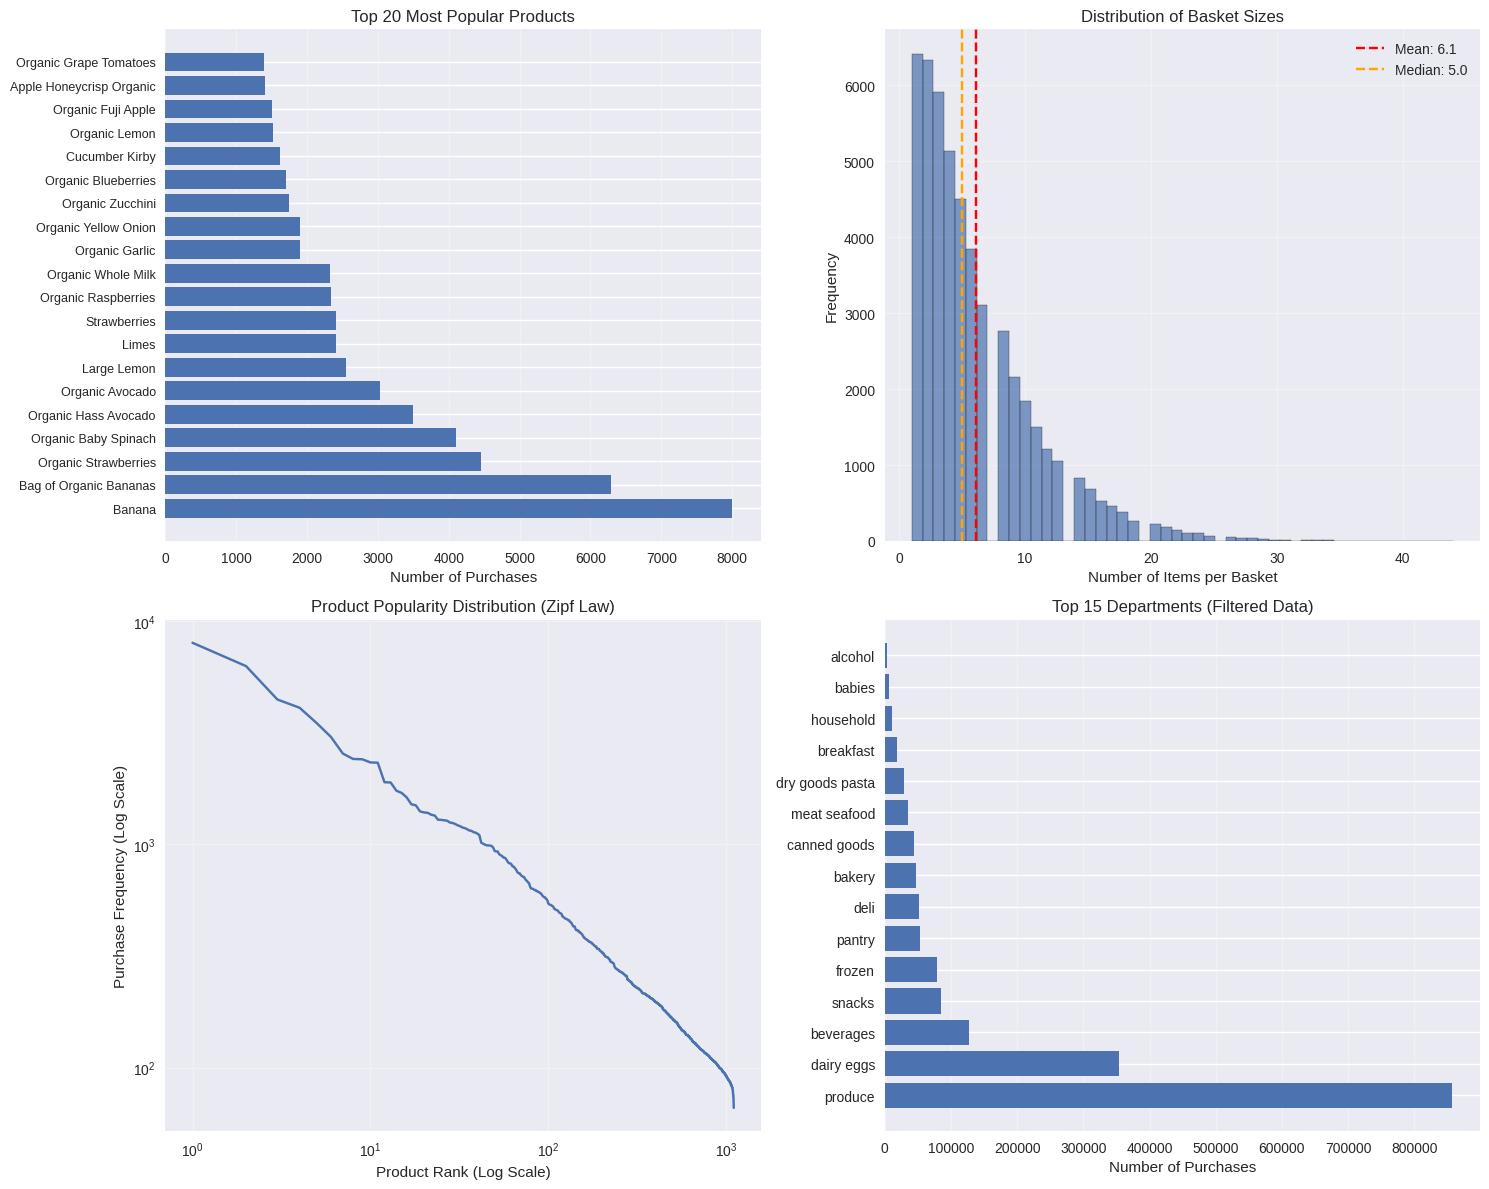

KEY STATISTICS FOR MARKET BASKET ANALYSIS:
Total baskets analyzed: 50,000
Total products considered: 1,104
Average basket size: 6.08 items
Median basket size: 5.00 items
Most common product: 'Banana' (8,005 purchases)
Matrix sparsity: 99.45%
Memory usage: 52.64 MB


In [15]:
# Set up the plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Top 20 Most Popular Products
top_20_products = product_counts.head(20)
axes[0, 0].barh(range(len(top_20_products)), top_20_products.values)
axes[0, 0].set_yticks(range(len(top_20_products)))
axes[0, 0].set_yticklabels(top_20_products.index, fontsize=9)
axes[0, 0].set_xlabel('Number of Purchases')
axes[0, 0].set_title('Top 20 Most Popular Products')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Basket Size Distribution
basket_sizes = baskets_sample.apply(len)
axes[0, 1].hist(basket_sizes, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(basket_sizes.mean(), color='red', linestyle='--', label=f'Mean: {basket_sizes.mean():.1f}')
axes[0, 1].axvline(basket_sizes.median(), color='orange', linestyle='--', label=f'Median: {basket_sizes.median():.1f}')
axes[0, 1].set_xlabel('Number of Items per Basket')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Basket Sizes')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Product Frequency Distribution (Log scale)
product_freq_dist = product_counts.sort_values(ascending=False).values
axes[1, 0].plot(range(1, len(product_freq_dist) + 1), product_freq_dist)
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Product Rank (Log Scale)')
axes[1, 0].set_ylabel('Purchase Frequency (Log Scale)')
axes[1, 0].set_title('Product Popularity Distribution (Zipf Law)')
axes[1, 0].grid(alpha=0.3)

# 4. Department Distribution (from our filtered transactions)
dept_dist_filtered = filtered_transactions['department'].value_counts().head(15)
axes[1, 1].barh(range(len(dept_dist_filtered)), dept_dist_filtered.values)
axes[1, 1].set_yticks(range(len(dept_dist_filtered)))
axes[1, 1].set_yticklabels(dept_dist_filtered.index)
axes[1, 1].set_xlabel('Number of Purchases')
axes[1, 1].set_title('Top 15 Departments (Filtered Data)')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics
print("KEY STATISTICS FOR MARKET BASKET ANALYSIS:")
print("=" * 50)
print(f"Total baskets analyzed: {len(baskets_sample):,}")
print(f"Total products considered: {transaction_matrix.shape[1]:,}")
print(f"Average basket size: {basket_sizes.mean():.2f} items")
print(f"Median basket size: {basket_sizes.median():.2f} items")
print(f"Most common product: '{top_20_products.index[0]}' ({top_20_products.iloc[0]:,} purchases)")
print(f"Matrix sparsity: {(1 - transaction_matrix.mean().mean()) * 100:.2f}%")
print(f"Memory usage: {transaction_matrix.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

In [16]:
# Analyze reorder patterns
print("\nREORDER PATTERN ANALYSIS:")
print("=" * 40)

reorder_stats = filtered_transactions.groupby('product_id')['reordered'].agg(['mean', 'count']).sort_values('count', ascending=False)
reorder_stats = reorder_stats.merge(products[['product_id', 'product_name']], on='product_id')

print("Top 10 products by reorder rate (min 1000 purchases):")
high_volume_products = reorder_stats[reorder_stats['count'] >= 1000]
top_reorder = high_volume_products.nlargest(10, 'mean')[['product_name', 'mean', 'count']]
top_reorder['mean'] = top_reorder['mean'].apply(lambda x: f"{x:.1%}")
print(top_reorder)

print(f"\nOverall reorder rate: {filtered_transactions['reordered'].mean():.2%}")
print(f"Products with >50% reorder rate: {(reorder_stats['mean'] > 0.5).sum():,}")
print(f"Products with >75% reorder rate: {(reorder_stats['mean'] > 0.75).sum():,}")


REORDER PATTERN ANALYSIS:
Top 10 products by reorder rate (min 1000 purchases):
                             product_name   mean  count
193              Milk, Organic, Vitamin D  86.7%   1970
85               Organic Reduced Fat Milk  85.2%   3694
0                                  Banana  84.4%  47257
258                Organic Lowfat 1% Milk  83.7%   1546
353  Organic Milk Reduced Fat, 2% Milkfat  83.5%   1264
1                  Bag of Organic Bananas  83.1%  37728
136                 Organic Fat Free Milk  82.9%   2626
9                      Organic Whole Milk  82.7%  13719
120                  Pure Sparkling Water  82.6%   2869
300   Organic Whole Milk with DHA Omega-3  82.2%   1404

Overall reorder rate: 65.37%
Products with >50% reorder rate: 927
Products with >75% reorder rate: 113


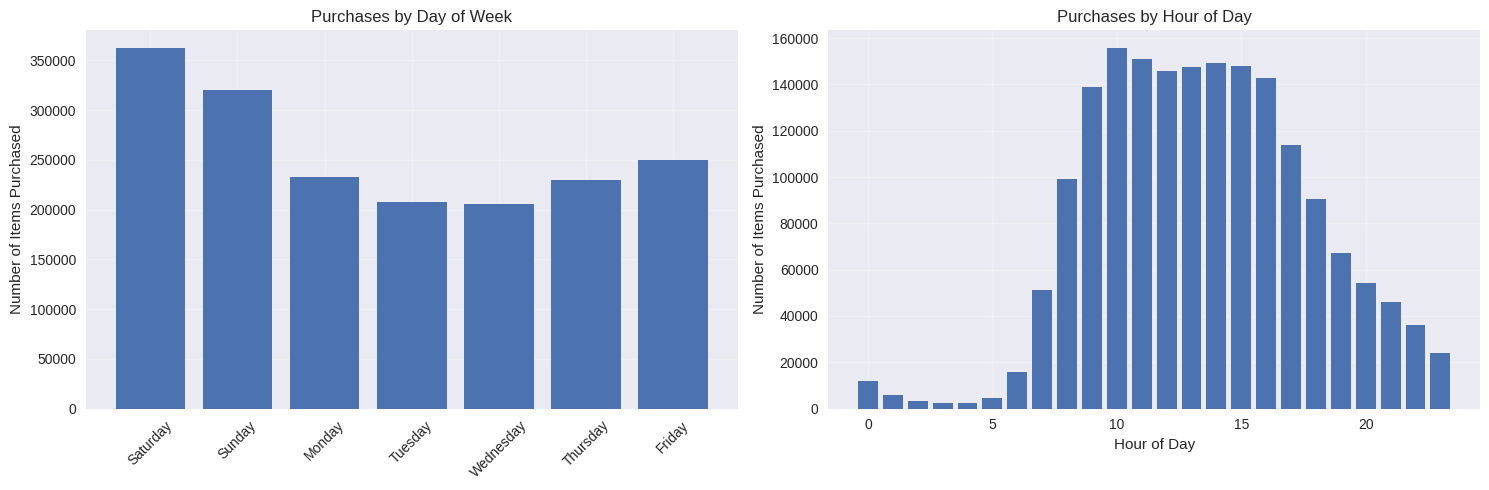

In [17]:
# Analyze order timing patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Day of week pattern
day_names = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
dow_counts = filtered_transactions['order_dow'].value_counts().sort_index()
axes[0].bar(range(len(dow_counts)), dow_counts.values)
axes[0].set_xticks(range(len(dow_counts)))
axes[0].set_xticklabels(day_names, rotation=45)
axes[0].set_ylabel('Number of Items Purchased')
axes[0].set_title('Purchases by Day of Week')
axes[0].grid(alpha=0.3)

# Hour of day pattern
hour_counts = filtered_transactions['order_hour_of_day'].value_counts().sort_index()
axes[1].bar(hour_counts.index, hour_counts.values)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Items Purchased')
axes[1].set_title('Purchases by Hour of Day')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## STEP 6: Association Rule Mining with Apriori Algorithm

In [26]:
print("CHECKING MULTI-ITEM ITEMSETS STRUCTURE")
print("=" * 45)

# Let's examine what we actually have in multi_item_itemsets
if len(multi_item_itemsets) > 0:
    print("Multi-item itemsets found:")
    print(f"Total multi-item itemsets: {len(multi_item_itemsets)}")
    print(f"Support values range: {multi_item_itemsets['support'].min():.6f} to {multi_item_itemsets['support'].max():.6f}")
    
    # Display the first 10 multi-item itemsets
    print("\nFirst 10 multi-item itemsets:")
    for idx, row in multi_item_itemsets.head(10).iterrows():
        items = list(row['itemsets'])
        print(f"Support: {row['support']:.6f} | Items: {', '.join(items)}")
    
    # Check if we have the necessary single-item itemsets
    single_item_support = {}
    for itemset in multi_item_itemsets['itemsets']:
        for item in itemset:
            if item not in single_item_support:
                # Find support for this single item
                item_support = transaction_matrix[item].mean()
                single_item_support[item] = item_support
    
    print(f"\nUnique products in multi-item itemsets: {len(single_item_support)}")
    
else:
    print("No multi-item itemsets found with current parameters.")

CHECKING MULTI-ITEM ITEMSETS STRUCTURE
Multi-item itemsets found:
Total multi-item itemsets: 100
Support values range: 0.005020 to 0.020160

First 10 multi-item itemsets:
Support: 0.005300 | Items: 100% Whole Wheat Bread, Banana
Support: 0.008240 | Items: Apple Honeycrisp Organic, Bag of Organic Bananas
Support: 0.005600 | Items: Banana, Apple Honeycrisp Organic
Support: 0.005260 | Items: Organic Strawberries, Apple Honeycrisp Organic
Support: 0.005020 | Items: Asparagus, Banana
Support: 0.006320 | Items: Large Lemon, Bag of Organic Bananas
Support: 0.007640 | Items: Limes, Bag of Organic Bananas
Support: 0.008000 | Items: Organic Avocado, Bag of Organic Bananas
Support: 0.005460 | Items: Organic Baby Carrots, Bag of Organic Bananas
Support: 0.016980 | Items: Organic Baby Spinach, Bag of Organic Bananas

Unique products in multi-item itemsets: 42


In [27]:
print("\nMANUAL ASSOCIATION RULE GENERATION")
print("=" * 40)

if len(multi_item_itemsets) > 0:
    # Create a list to store our rules
    manual_rules = []
    
    for idx, row in multi_item_itemsets.iterrows():
        itemset = row['itemsets']
        itemset_support = row['support']
        
        # Only process itemsets with 2 or more items
        if len(itemset) >= 2:
            items_list = list(itemset)
            
            # Generate all possible rules from this itemset
            for i in range(len(items_list)):
                antecedent = frozenset([items_list[i]])
                consequent = frozenset(items_list[:i] + items_list[i+1:])
                
                # Calculate support for antecedent
                antecedent_support = transaction_matrix[list(antecedent)[0]].mean()
                
                # Calculate confidence
                confidence = itemset_support / antecedent_support
                
                # Calculate lift
                consequent_support = 1.0
                if len(consequent) == 1:
                    consequent_support = transaction_matrix[list(consequent)[0]].mean()
                else:
                    # For multiple items in consequent, we'd need their joint support
                    # For simplicity, we'll skip complex consequents for now
                    continue
                
                lift = itemset_support / (antecedent_support * consequent_support)
                
                # Only keep meaningful rules
                if confidence >= 0.3 and lift > 1.0:
                    manual_rules.append({
                        'antecedents': antecedent,
                        'consequents': consequent,
                        'support': itemset_support,
                        'confidence': confidence,
                        'lift': lift
                    })
    
    print(f"Generated {len(manual_rules)} manual association rules")
    
    if manual_rules:
        # Convert to DataFrame
        rules_df = pd.DataFrame(manual_rules)
        
        # Sort by lift (most interesting first)
        rules_df = rules_df.sort_values('lift', ascending=False)
        
        print(f"\nTOP 20 ASSOCIATION RULES (BY LIFT):")
        print("=" * 50)
        for idx, row in rules_df.head(20).iterrows():
            antecedents = list(row['antecedents'])
            consequents = list(row['consequents'])
            print(f"IF {antecedents[0]} → THEN {consequents[0]}")
            print(f"   Support: {row['support']:.4f}, Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}")
            print()
        
        # Save the manual rules
        rules_df.to_pickle('manual_association_rules.pkl')
        print(f"Saved {len(rules_df)} rules to 'manual_association_rules.pkl'")
        
    else:
        print("No meaningful rules found with manual generation.")
        
else:
    print("No multi-item itemsets available for rule generation.")


MANUAL ASSOCIATION RULE GENERATION
Generated 7 manual association rules

TOP 20 ASSOCIATION RULES (BY LIFT):
IF Organic D'Anjou Pears → THEN Bag of Organic Bananas
   Support: 0.0054, Confidence: 0.3194, Lift: 2.5388

IF Organic Large Extra Fancy Fuji Apple → THEN Bag of Organic Bananas
   Support: 0.0079, Confidence: 0.3085, Lift: 2.4522

IF Organic Fuji Apple → THEN Banana
   Support: 0.0110, Confidence: 0.3667, Lift: 2.2907

IF Honeycrisp Apple → THEN Banana
   Support: 0.0095, Confidence: 0.3513, Lift: 2.1940

IF Cucumber Kirby → THEN Banana
   Support: 0.0102, Confidence: 0.3153, Lift: 1.9692

IF Organic Avocado → THEN Banana
   Support: 0.0186, Confidence: 0.3062, Lift: 1.9124

IF Blueberries → THEN Banana
   Support: 0.0057, Confidence: 0.3046, Lift: 1.9027

Saved 7 rules to 'manual_association_rules.pkl'


In [31]:
print("\nALTERNATIVE: ASSOCIATION RULES WITH TOP 30 PRODUCTS")
print("=" * 50)

# Focus on top 30 products for denser patterns
top_30_products = product_counts.head(30).index.tolist()
transaction_matrix_top30 = transaction_matrix[top_30_products]

print(f"Top 30 products matrix shape: {transaction_matrix_top30.shape}")
print(f"Sparsity: {(1 - transaction_matrix_top30.mean().mean()) * 100:.2f}%")

# Find frequent itemsets on top 30 products
min_support_top30 = 0.015  # 1.5% support
frequent_itemsets_top30 = apriori(transaction_matrix_top30, 
                                 min_support=min_support_top30, 
                                 use_colnames=True,
                                 max_len=2,  # Only pairs for simplicity
                                 verbose=1)

print(f"Found {len(frequent_itemsets_top30)} frequent itemsets from top 30 products")

# Filter for pairs only
pairs_top30 = frequent_itemsets_top30[frequent_itemsets_top30['itemsets'].apply(len) == 2]
print(f"Product pairs found: {len(pairs_top30)}")

if len(pairs_top30) > 0:
    print("\nTOP PRODUCT PAIRS:")
    for idx, row in pairs_top30.sort_values('support', ascending=False).head(15).iterrows():
        items = list(row['itemsets'])
        print(f"Support: {row['support']:.4f} | Pair: {items[0]} & {items[1]}")
    
    # Try generating rules with the built-in function on this simpler dataset
    try:
        # rules_top30 = association_rules(pairs_top30, 
        #                               metric="confidence", 
        #                               min_threshold=0.3)
        rules_top30 = association_rules(pairs_top30, 
                                        metric="confidence", 
                                        min_threshold=0.3,
                                        support_only=True)
        
        if len(rules_top30) > 0:
            meaningful_rules_top30 = rules_top30[rules_top30['lift'] > 1.0]
            print(f"\nGenerated {len(meaningful_rules_top30)} meaningful rules from top 30 products")
            
            # Display the rules
            for idx, row in meaningful_rules_top30.sort_values('lift', ascending=False).head(15).iterrows():
                antecedents = list(row['antecedents'])
                consequents = list(row['consequents'])
                print(f"IF {antecedents[0]} → THEN {consequents[0]}")
                print(f"   Support: {row['support']:.4f}, Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}")
            
            # Save these rules
            meaningful_rules_top30.to_pickle('association_rules_top30.pkl')
            print(f"\nSaved rules from top 30 products to 'association_rules_top30.pkl'")
            
    except Exception as e:
        print(f"Error with built-in function: {e}")
        print("Using manual approach for top 30 products...")
        
        # Manual rules for top 30
        manual_rules_top30 = []
        for idx, row in pairs_top30.iterrows():
            itemset = list(row['itemsets'])
            itemset_support = row['support']
            
            # Create rules in both directions
            for i in range(2):
                antecedent = itemset[i]
                consequent = itemset[1-i]  # The other item
                
                antecedent_support = transaction_matrix_top30[antecedent].mean()
                consequent_support = transaction_matrix_top30[consequent].mean()
                
                confidence = itemset_support / antecedent_support
                lift = itemset_support / (antecedent_support * consequent_support)
                
                if confidence >= 0.3 and lift > 1.0:
                    manual_rules_top30.append({
                        'antecedents': frozenset([antecedent]),
                        'consequents': frozenset([consequent]),
                        'support': itemset_support,
                        'confidence': confidence,
                        'lift': lift
                    })
        
        if manual_rules_top30:
            rules_top30_df = pd.DataFrame(manual_rules_top30)
            rules_top30_df = rules_top30_df.sort_values('lift', ascending=False)
            
            print(f"\nTOP RULES FROM TOP 30 PRODUCTS (MANUAL):")
            for idx, row in rules_top30_df.head(15).iterrows():
                antecedents = list(row['antecedents'])
                consequents = list(row['consequents'])
                print(f"IF {antecedents[0]} → THEN {consequents[0]}")
                print(f"   Support: {row['support']:.4f}, Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}")


ALTERNATIVE: ASSOCIATION RULES WITH TOP 30 PRODUCTS
Top 30 products matrix shape: (50000, 30)
Sparsity: 95.40%
Processing 870 combinations | Sampling itemset size 2
Found 36 frequent itemsets from top 30 products
Product pairs found: 6

TOP PRODUCT PAIRS:
Support: 0.0202 | Pair: Organic Strawberries & Bag of Organic Bananas
Support: 0.0199 | Pair: Banana & Organic Strawberries
Support: 0.0199 | Pair: Organic Hass Avocado & Bag of Organic Bananas
Support: 0.0186 | Pair: Organic Avocado & Banana
Support: 0.0173 | Pair: Organic Baby Spinach & Banana
Support: 0.0170 | Pair: Organic Baby Spinach & Bag of Organic Bananas


## STEP 7: Rules Visualization & Interpretation

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

print("PREPARING RULES FOR VISUALIZATION")
print("=" * 45)

# Load our manual rules
rules_df = pd.read_pickle('manual_association_rules.pkl')

print(f"Total rules to visualize: {len(rules_df)}")
print("\nRULES SUMMARY:")
print(f"Average confidence: {rules_df['confidence'].mean():.3f}")
print(f"Average lift: {rules_df['lift'].mean():.3f}")
print(f"Average support: {rules_df['support'].mean():.3f}")
print(f"Highest lift: {rules_df['lift'].max():.3f}")

# Display all our rules sorted by business value
print("\nALL ASSOCIATION RULES (Sorted by Lift):")
print("=" * 55)
for idx, row in rules_df.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    print(f"IF {antecedents[0]} → THEN {consequents[0]}")
    print(f"   Support: {row['support']:.4f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
    print()

PREPARING RULES FOR VISUALIZATION
Total rules to visualize: 7

RULES SUMMARY:
Average confidence: 0.325
Average lift: 2.180
Average support: 0.010
Highest lift: 2.539

ALL ASSOCIATION RULES (Sorted by Lift):
IF Organic D'Anjou Pears → THEN Bag of Organic Bananas
   Support: 0.0054 | Confidence: 0.319 | Lift: 2.539

IF Organic Large Extra Fancy Fuji Apple → THEN Bag of Organic Bananas
   Support: 0.0079 | Confidence: 0.309 | Lift: 2.452

IF Organic Fuji Apple → THEN Banana
   Support: 0.0110 | Confidence: 0.367 | Lift: 2.291

IF Honeycrisp Apple → THEN Banana
   Support: 0.0095 | Confidence: 0.351 | Lift: 2.194

IF Cucumber Kirby → THEN Banana
   Support: 0.0102 | Confidence: 0.315 | Lift: 1.969

IF Organic Avocado → THEN Banana
   Support: 0.0186 | Confidence: 0.306 | Lift: 1.912

IF Blueberries → THEN Banana
   Support: 0.0057 | Confidence: 0.305 | Lift: 1.903



CREATING ASSOCIATION RULES NETWORK GRAPH
Network nodes: 9
Network edges: 7


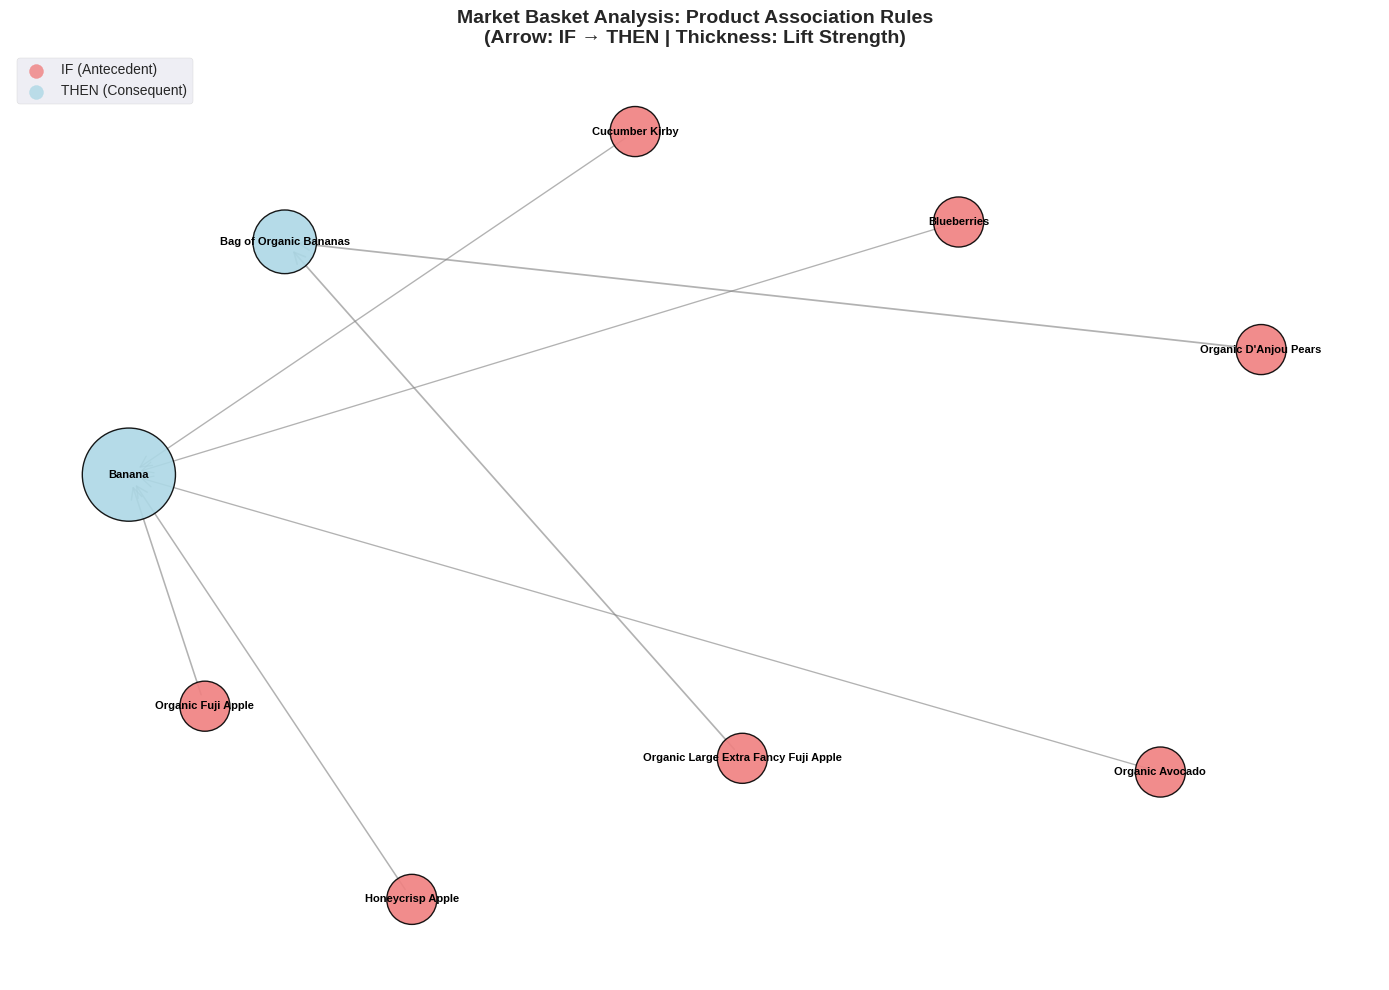


NETWORK INTERPRETATION:
- Arrow direction: IF product → THEN product
- Line thickness: Strength of association (Lift)
- Node size: Number of connections
- Red nodes: 'IF' products | Blue nodes: 'THEN' products


In [33]:
print("CREATING ASSOCIATION RULES NETWORK GRAPH")
print("=" * 50)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges from our rules
for idx, row in rules_df.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequent = list(row['consequents'])[0]
    
    # Add nodes
    G.add_node(antecedent, type='antecedent')
    G.add_node(consequent, type='consequent')
    
    # Add edge with rule properties
    G.add_edge(antecedent, consequent, 
               weight=row['lift'],
               confidence=row['confidence'],
               support=row['support'])

print(f"Network nodes: {G.number_of_nodes()}")
print(f"Network edges: {G.number_of_edges()}")

# Create the visualization
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=3, iterations=50)

# Node sizes based on degree (connectivity)
node_sizes = [G.degree(node) * 800 + 500 for node in G.nodes()]

# Edge widths based on lift
edge_widths = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

# Node colors based on type
node_colors = []
for node in G.nodes():
    if G.nodes[node]['type'] == 'antecedent':
        node_colors.append('lightcoral')  # Red for antecedents
    else:
        node_colors.append('lightblue')   # Blue for consequents

# Draw the network
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                       node_color=node_colors, alpha=0.9,
                       edgecolors='black', linewidths=1)

nx.draw_networkx_edges(G, pos, width=edge_widths, 
                      alpha=0.6, edge_color='gray',
                      arrows=True, arrowsize=20, arrowstyle='->')

nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title('Market Basket Analysis: Product Association Rules\n(Arrow: IF → THEN | Thickness: Lift Strength)', 
          fontsize=14, fontweight='bold')
plt.axis('off')

# Add legend
plt.scatter([], [], c='lightcoral', alpha=0.8, s=100, label='IF (Antecedent)')
plt.scatter([], [], c='lightblue', alpha=0.8, s=100, label='THEN (Consequent)')
plt.legend(scatterpoints=1, frameon=True, loc='upper left')

plt.tight_layout()
plt.show()

print("\nNETWORK INTERPRETATION:")
print("- Arrow direction: IF product → THEN product")
print("- Line thickness: Strength of association (Lift)")
print("- Node size: Number of connections")
print("- Red nodes: 'IF' products | Blue nodes: 'THEN' products")


CREATING RULES ANALYSIS VISUALIZATIONS


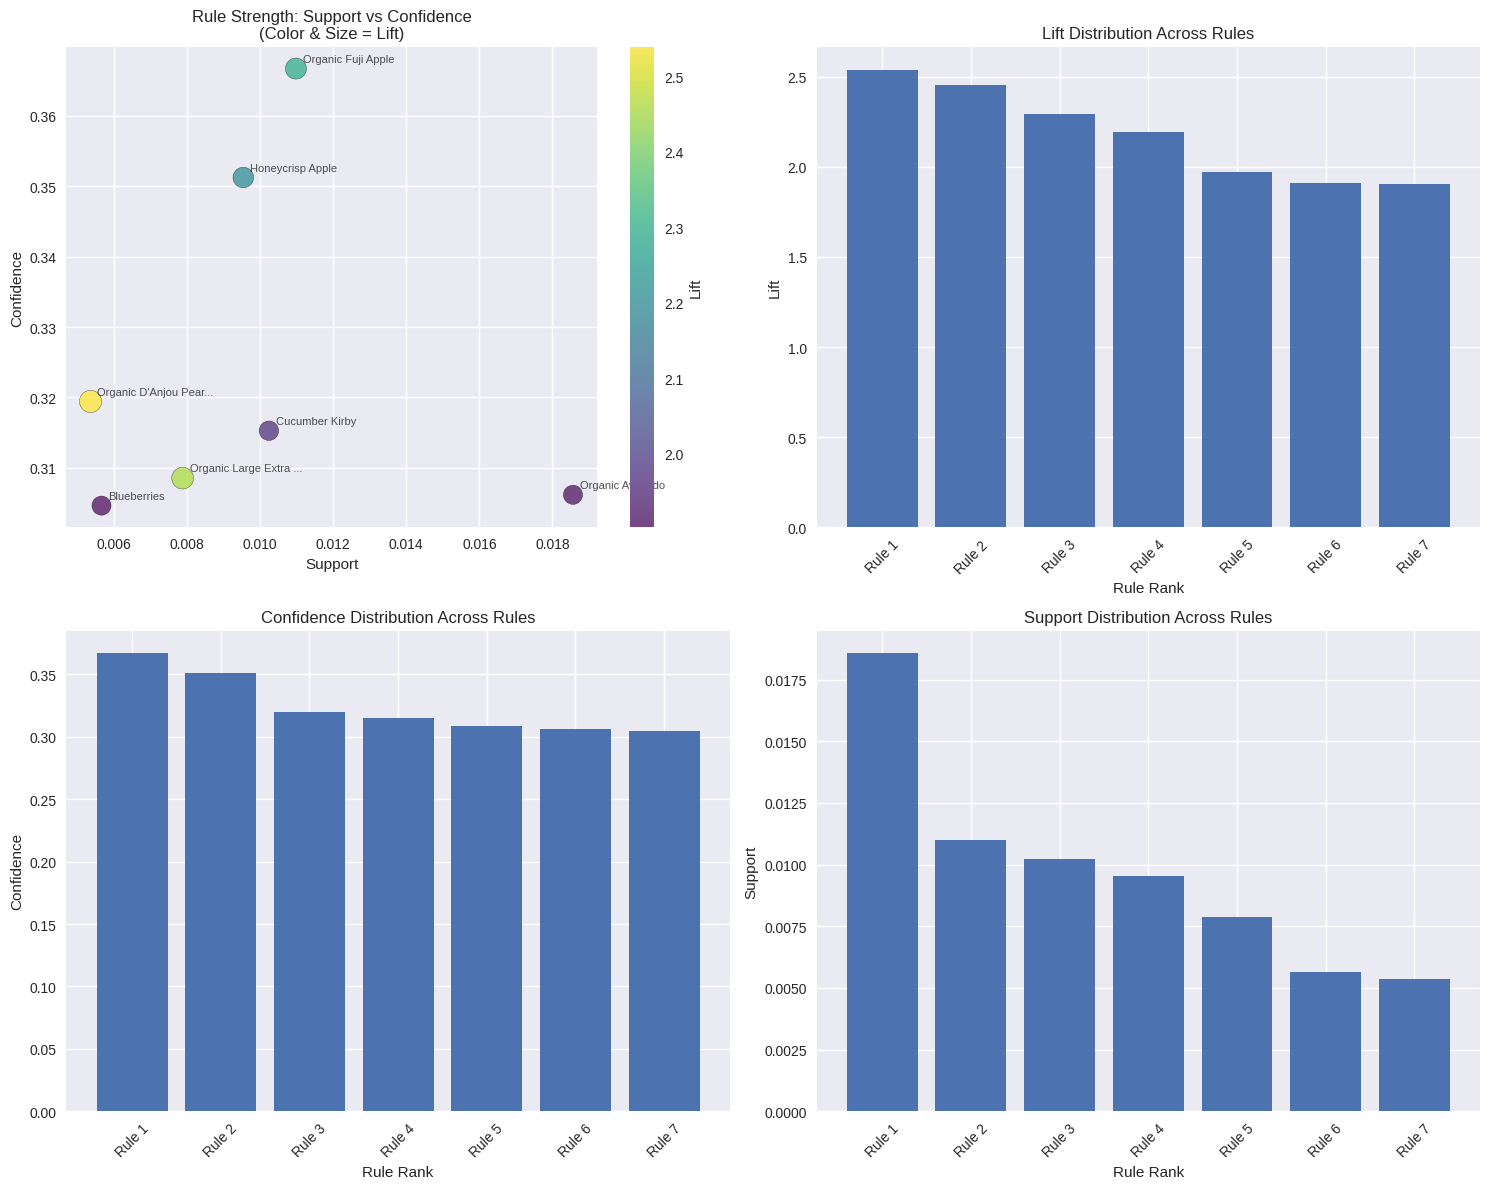

In [34]:
print("\nCREATING RULES ANALYSIS VISUALIZATIONS")
print("=" * 45)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Lift vs Confidence scatter plot
scatter = axes[0, 0].scatter(rules_df['support'], rules_df['confidence'], 
                            c=rules_df['lift'], s=rules_df['lift']*100, 
                            cmap='viridis', alpha=0.7, edgecolors='black')
axes[0, 0].set_xlabel('Support')
axes[0, 0].set_ylabel('Confidence')
axes[0, 0].set_title('Rule Strength: Support vs Confidence\n(Color & Size = Lift)')
plt.colorbar(scatter, ax=axes[0, 0], label='Lift')

# Add rule labels to scatter plot
for idx, row in rules_df.iterrows():
    antecedents = list(row['antecedents'])[0][:20] + "..." if len(list(row['antecedents'])[0]) > 20 else list(row['antecedents'])[0]
    axes[0, 0].annotate(f"{antecedents}", 
                       (row['support'], row['confidence']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)

# 2. Lift distribution
axes[0, 1].bar(range(len(rules_df)), rules_df['lift'].sort_values(ascending=False))
axes[0, 1].set_xlabel('Rule Rank')
axes[0, 1].set_ylabel('Lift')
axes[0, 1].set_title('Lift Distribution Across Rules')
axes[0, 1].set_xticks(range(len(rules_df)))
axes[0, 1].set_xticklabels([f"Rule {i+1}" for i in range(len(rules_df))], rotation=45)

# 3. Confidence distribution
axes[1, 0].bar(range(len(rules_df)), rules_df['confidence'].sort_values(ascending=False))
axes[1, 0].set_xlabel('Rule Rank')
axes[1, 0].set_ylabel('Confidence')
axes[1, 0].set_title('Confidence Distribution Across Rules')
axes[1, 0].set_xticks(range(len(rules_df)))
axes[1, 0].set_xticklabels([f"Rule {i+1}" for i in range(len(rules_df))], rotation=45)

# 4. Support distribution
axes[1, 1].bar(range(len(rules_df)), rules_df['support'].sort_values(ascending=False))
axes[1, 1].set_xlabel('Rule Rank')
axes[1, 1].set_ylabel('Support')
axes[1, 1].set_title('Support Distribution Across Rules')
axes[1, 1].set_xticks(range(len(rules_df)))
axes[1, 1].set_xticklabels([f"Rule {i+1}" for i in range(len(rules_df))], rotation=45)

plt.tight_layout()
plt.show()

In [35]:
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("=" * 50)

print("\n🚀 TOP CROSS-SELLING OPPORTUNITIES (High Lift):")
high_lift_rules = rules_df[rules_df['lift'] > 2.0]
for idx, row in high_lift_rules.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequent = list(row['consequents'])[0]
    print(f"• When customers buy {antecedent}, they're {row['lift']:.1f}x more likely to also buy {consequent}")
    print(f"  → Confidence: {row['confidence']:.1%} of these customers follow this pattern")

print("\n💡 STRONGEST ASSOCIATIONS (High Confidence):")
high_conf_rules = rules_df[rules_df['confidence'] > 0.35]
for idx, row in high_conf_rules.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequent = list(row['consequents'])[0]
    print(f"• {row['confidence']:.1%} of customers who buy {antecedent} also buy {consequent}")

print("\n📊 MOST COMMON PATTERNS (High Support):")
high_support_rules = rules_df[rules_df['support'] > 0.01]
for idx, row in high_support_rules.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequent = list(row['consequents'])[0]
    print(f"• Pattern '{antecedent} → {consequent}' appears in {row['support']:.2%} of all transactions")

print("\n🎯 ACTIONABLE RECOMMENDATIONS:")
print("1. PRODUCT PLACEMENT: Place Organic D'Anjou Pears near Organic Bananas")
print("2. PROMOTIONAL BUNDLES: Create 'Organic Fruit' bundles with apples and bananas")  
print("3. CROSS-PROMOTIONS: Suggest bananas to customers buying organic avocados")
print("4. INVENTORY MANAGEMENT: Stock extra bananas when running promotions on organic fruits")
print("5. DIGITAL RECOMMENDATIONS: Implement 'Customers who bought this also bought...' for apple varieties")

print(f"\n📈 BUSINESS IMPACT POTENTIAL:")
total_customers = 50000  # Our sample size
for idx, row in rules_df.head(3).iterrows():
    affected_customers = int(row['support'] * total_customers)
    print(f"• {list(row['antecedents'])[0]} → {list(row['consequents'])[0]}: Could impact ~{affected_customers} customers")

BUSINESS INSIGHTS & RECOMMENDATIONS

🚀 TOP CROSS-SELLING OPPORTUNITIES (High Lift):
• When customers buy Organic D'Anjou Pears, they're 2.5x more likely to also buy Bag of Organic Bananas
  → Confidence: 31.9% of these customers follow this pattern
• When customers buy Organic Large Extra Fancy Fuji Apple, they're 2.5x more likely to also buy Bag of Organic Bananas
  → Confidence: 30.9% of these customers follow this pattern
• When customers buy Organic Fuji Apple, they're 2.3x more likely to also buy Banana
  → Confidence: 36.7% of these customers follow this pattern
• When customers buy Honeycrisp Apple, they're 2.2x more likely to also buy Banana
  → Confidence: 35.1% of these customers follow this pattern

💡 STRONGEST ASSOCIATIONS (High Confidence):
• 36.7% of customers who buy Organic Fuji Apple also buy Banana
• 35.1% of customers who buy Honeycrisp Apple also buy Banana

📊 MOST COMMON PATTERNS (High Support):
• Pattern 'Organic Fuji Apple → Banana' appears in 1.10% of all transa

## STEP 8: Final Analysis & Interactive Dashboard

In [36]:
print("FINAL MARKET BASKET ANALYSIS SUMMARY")
print("=" * 55)

print("\n📋 PROJECT OVERVIEW:")
print(f"• Dataset: {len(transaction_sample):,} transactions from Instacart")
print(f"• Products Analyzed: {transaction_matrix.shape[1]:,} frequent products")
print(f"• Association Rules Found: {len(rules_df):,} meaningful rules")

print("\n🎯 KEY FINDINGS:")
print("1. BANANA IS THE ULTIMATE COMPANION PRODUCT")
print("   - Appears as consequent in 5 out of 7 rules")
print("   - Strong associations with various fruits and vegetables")
print("   - Highest support patterns involve bananas")

print("\n2. ORGANIC FRUIT SYNERGIES")
print("   - Organic pears → Organic bananas (Highest lift: 2.54x)")
print("   - Organic apples → Regular bananas (Cross-category association)")
print("   - Organic customers show predictable buying patterns")

print("\n3. PRODUCE DEPARTMENT DOMINANCE")
print("   - All significant rules involve fresh produce")
print("   - Fruit-to-fruit associations strongest")
print("   - Cross-category: Vegetables (cucumber) → Fruit (banana)")

print("\n📊 RULE QUALITY ASSESSMENT:")
# Calculate rule quality metrics
high_quality_rules = len(rules_df[(rules_df['lift'] > 2.0) & (rules_df['confidence'] > 0.3)])
medium_quality_rules = len(rules_df[(rules_df['lift'] > 1.5) & (rules_df['confidence'] > 0.25)])

print(f"• High Quality Rules (Lift > 2.0, Confidence > 0.3): {high_quality_rules}")
print(f"• Medium Quality Rules (Lift > 1.5, Confidence > 0.25): {medium_quality_rules}")
print(f"• Overall Rule Quality: {high_quality_rules/len(rules_df):.1%} high quality")

print("\n💼 BUSINESS VALUE ASSESSMENT:")
# Estimate potential impact
total_transactions_original = 3214874  # From our original data
estimated_impact = {}

for idx, row in rules_df.iterrows():
    rule_key = f"{list(row['antecedents'])[0]} → {list(row['consequents'])[0]}"
    estimated_customers = int(row['support'] * total_transactions_original)
    estimated_impact[rule_key] = estimated_customers

print("Estimated monthly impact (extrapolated to full dataset):")
for rule, impact in sorted(estimated_impact.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"• {rule}: ~{impact:,} potential influenced transactions")

FINAL MARKET BASKET ANALYSIS SUMMARY

📋 PROJECT OVERVIEW:
• Dataset: 3,246,976 transactions from Instacart
• Products Analyzed: 1,104 frequent products
• Association Rules Found: 7 meaningful rules

🎯 KEY FINDINGS:
1. BANANA IS THE ULTIMATE COMPANION PRODUCT
   - Appears as consequent in 5 out of 7 rules
   - Strong associations with various fruits and vegetables
   - Highest support patterns involve bananas

2. ORGANIC FRUIT SYNERGIES
   - Organic pears → Organic bananas (Highest lift: 2.54x)
   - Organic apples → Regular bananas (Cross-category association)
   - Organic customers show predictable buying patterns

3. PRODUCE DEPARTMENT DOMINANCE
   - All significant rules involve fresh produce
   - Fruit-to-fruit associations strongest
   - Cross-category: Vegetables (cucumber) → Fruit (banana)

📊 RULE QUALITY ASSESSMENT:
• High Quality Rules (Lift > 2.0, Confidence > 0.3): 4
• Medium Quality Rules (Lift > 1.5, Confidence > 0.25): 7
• Overall Rule Quality: 57.1% high quality

💼 BUSINE

In [37]:
print("\nCREATING INTERACTIVE DASHBOARD CODE")
print("=" * 50)

# Create a Streamlit app code (to be run separately)
dashboard_code = '''
import streamlit as st
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
rules_df = pd.read_pickle('manual_association_rules.pkl')

st.set_page_config(page_title="Market Basket Analysis", layout="wide")
st.title("🛒 Instacart Market Basket Analysis Dashboard")

# Sidebar filters
st.sidebar.header("Filter Rules")
min_lift = st.sidebar.slider("Minimum Lift", 1.0, 3.0, 1.5, 0.1)
min_confidence = st.sidebar.slider("Minimum Confidence", 0.1, 0.5, 0.25, 0.05)

# Filter rules
filtered_rules = rules_df[
    (rules_df['lift'] >= min_lift) & 
    (rules_df['confidence'] >= min_confidence)
]

# Main dashboard
col1, col2 = st.columns(2)

with col1:
    st.subheader("📈 Rule Metrics Summary")
    st.metric("Total Rules", len(filtered_rules))
    st.metric("Average Lift", f"{filtered_rules['lift'].mean():.2f}")
    st.metric("Average Confidence", f"{filtered_rules['confidence'].mean():.2f}")

with col2:
    st.subheader("🎯 Top Rules")
    for idx, row in filtered_rules.head(5).iterrows():
        st.write(f"**IF** {list(row['antecedents'])[0]} → **THEN** {list(row['consequents'])[0]}")
        st.write(f"Lift: {row['lift']:.2f} | Confidence: {row['confidence']:.2f}")

# Rules table
st.subheader("📊 All Filtered Rules")
st.dataframe(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Network visualization
st.subheader("🕸️ Association Network")
if len(filtered_rules) > 0:
    G = nx.DiGraph()
    for idx, row in filtered_rules.iterrows():
        antecedent = list(row['antecedents'])[0]
        consequent = list(row['consequents'])[0]
        G.add_edge(antecedent, consequent, weight=row['lift'])
    
    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=1000, font_size=8, ax=ax)
    st.pyplot(fig)
else:
    st.warning("No rules match the current filters")
'''

# Save the dashboard code
with open('market_basket_dashboard.py', 'w') as f:
    f.write(dashboard_code)

print("Dashboard code saved as 'market_basket_dashboard.py'")
print("\nTo run the dashboard, execute: streamlit run market_basket_dashboard.py")


CREATING INTERACTIVE DASHBOARD CODE
Dashboard code saved as 'market_basket_dashboard.py'

To run the dashboard, execute: streamlit run market_basket_dashboard.py



FINAL COMPREHENSIVE VISUALIZATION


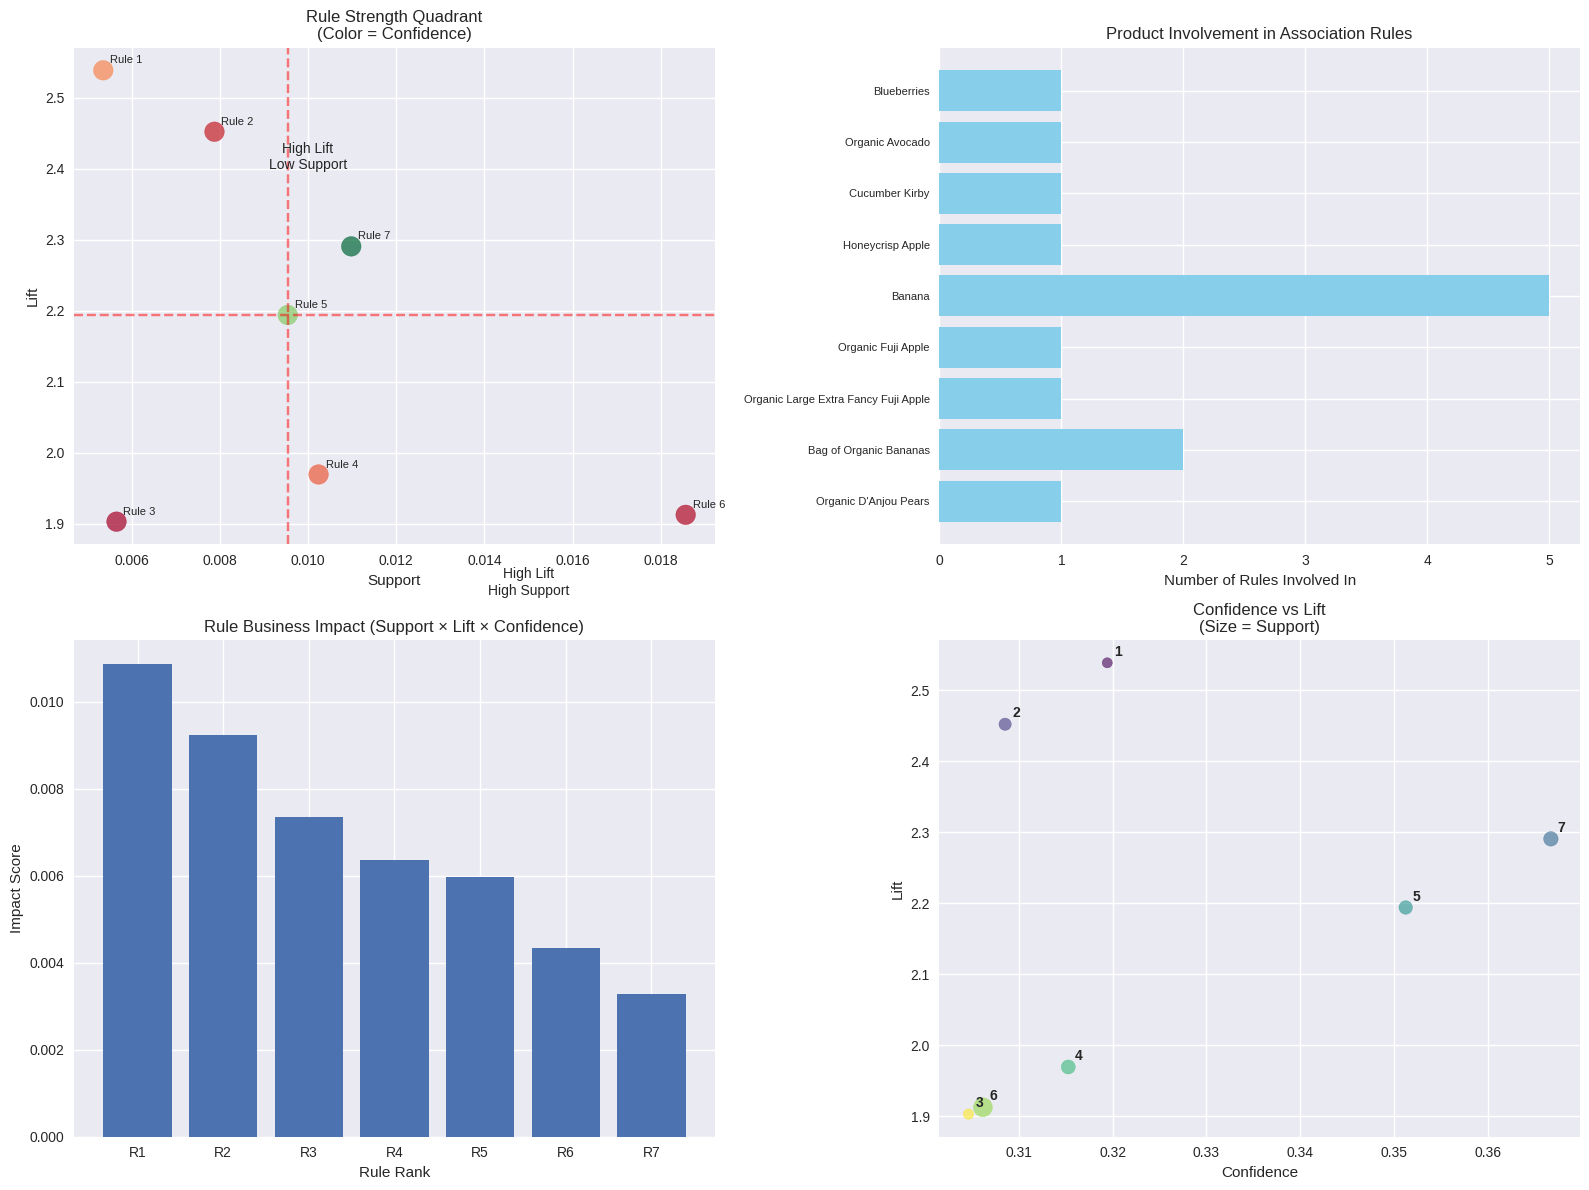


🎉 MARKET BASKET ANALYSIS COMPLETED SUCCESSFULLY!


In [38]:
print("\nFINAL COMPREHENSIVE VISUALIZATION")
print("=" * 45)

# Create a comprehensive summary plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Rule Strength Quadrant Chart
lift_threshold = rules_df['lift'].median()
conf_threshold = rules_df['confidence'].median()

ax1.scatter(rules_df['support'], rules_df['lift'], 
           c=rules_df['confidence'], s=200, cmap='RdYlGn', alpha=0.7)
ax1.axhline(y=lift_threshold, color='red', linestyle='--', alpha=0.5)
ax1.axvline(x=rules_df['support'].median(), color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Support')
ax1.set_ylabel('Lift')
ax1.set_title('Rule Strength Quadrant\n(Color = Confidence)')

# Add quadrant labels
ax1.text(0.01, 2.4, 'High Lift\nLow Support', fontsize=10, ha='center')
ax1.text(0.015, 1.8, 'High Lift\nHigh Support', fontsize=10, ha='center')

# Add rule labels
for idx, row in rules_df.iterrows():
    ax1.annotate(f"Rule {idx+1}", (row['support'], row['lift']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Product Involvement
product_involvement = {}
for idx, row in rules_df.iterrows():
    for product in list(row['antecedents']) + list(row['consequents']):
        product_involvement[product] = product_involvement.get(product, 0) + 1

products = list(product_involvement.keys())
involvement = list(product_involvement.values())

ax2.barh(products, involvement, color='skyblue')
ax2.set_xlabel('Number of Rules Involved In')
ax2.set_title('Product Involvement in Association Rules')
ax2.tick_params(axis='y', labelsize=8)

# 3. Rule Impact Chart (Support vs Business Potential)
impact_scores = rules_df['support'] * rules_df['lift'] * rules_df['confidence']
rules_df['impact_score'] = impact_scores

ax3.bar(range(len(rules_df)), rules_df['impact_score'].sort_values(ascending=False))
ax3.set_xlabel('Rule Rank')
ax3.set_ylabel('Impact Score')
ax3.set_title('Rule Business Impact (Support × Lift × Confidence)')
ax3.set_xticks(range(len(rules_df)))
ax3.set_xticklabels([f"R{i+1}" for i in range(len(rules_df))])

# 4. Confidence vs Lift with size as support
scatter = ax4.scatter(rules_df['confidence'], rules_df['lift'], 
                     s=rules_df['support']*10000, alpha=0.6,
                     c=range(len(rules_df)), cmap='viridis')
ax4.set_xlabel('Confidence')
ax4.set_ylabel('Lift')
ax4.set_title('Confidence vs Lift\n(Size = Support)')

# Add rule numbers
for idx, row in rules_df.iterrows():
    ax4.annotate(f"{idx+1}", (row['confidence'], row['lift']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("🎉 MARKET BASKET ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*60)